In [177]:
import itertools
import glob
import numpy as np
import pickle as pkl
import torch 
from torchvision import datasets, transforms
# from utils import * # get the dataset
from pyhessian import hessian # Hessian computation
# from density_plot import get_esd_plot # ESD plot
# from pytorchcv.model_provider import get_model as ptcv_get_model # model
from swadist.models import ResNet
from swadist.data import get_dataloaders

import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rcParams['figure.dpi'] = 250
plt.rcParams["font.family"] = "serif"
plt.rcParams["font.size"] = "14"

# replace with 128 etc
BATCH = 'bs64'

In [138]:
def get_esd_plot(eigenvalues, weights):
    density, grids = density_generate(eigenvalues, weights)
    plt.semilogy(grids, density + 1.0e-7)
    plt.ylabel('Density (Log Scale)', fontsize=14, labelpad=10)
    plt.xlabel('Eigenvalue', fontsize=14, labelpad=10)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.axis([np.min(eigenvalues) - 1, np.max(eigenvalues) + 1, None, None])
    plt.tight_layout()
    plt.title('Distribution of Hessian eigenvalues')

def density_generate(eigenvalues,
                     weights,
                     num_bins=10000,
                     sigma_squared=1e-5,
                     overhead=0.01):

    eigenvalues = np.array(eigenvalues)
    weights = np.array(weights)

    lambda_max = np.mean(np.max(eigenvalues, axis=1), axis=0) + overhead
    lambda_min = np.mean(np.min(eigenvalues, axis=1), axis=0) - overhead

    grids = np.linspace(lambda_min, lambda_max, num=num_bins)
    sigma = sigma_squared * max(1, (lambda_max - lambda_min))

    num_runs = eigenvalues.shape[0]
    density_output = np.zeros((num_runs, num_bins))

    for i in range(num_runs):
        for j in range(num_bins):
            x = grids[j]
            tmp_result = gaussian(eigenvalues[i, :], x, sigma)
            density_output[i, j] = np.sum(tmp_result * weights[i, :])
    density = np.mean(density_output, axis=0)
    normalization = np.sum(density) * (grids[1] - grids[0])
    density = density / normalization
    return density, grids

def gaussian(x, x0, sigma_squared):
    return np.exp(-(x0 - x)**2 /
                  (2.0 * sigma_squared)) / np.sqrt(2 * np.pi * sigma_squared)

In [139]:
# enable cuda devices
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="0"

In [140]:
state_dict_dir = 'results/state_dicts/2022-05-13-commit-901fcc2'

if not os.path.exists(state_dict_dir):
    import tarfile
    tar = tarfile.open(f'{state_dict_dir}.tar.gz')
    tar.extractall('results/state_dicts/')
    tar.close()

In [141]:
all_state_dicts_in_dir = os.listdir(state_dict_dir)

# just use rank 0 for plot
all_state_dicts_in_dir = [p for p in all_state_dicts_in_dir if 'rank1' not in p and p[-3:] == '.pt']

In [142]:
# replace with 128 etc
currbs_paths = [p for p in all_state_dicts_in_dir if BATCH in p]

In [143]:
import torch 
if not os.path.exists(state_dict_dir + f'/zvalues_{BATCH}.pkl'):
    z_values = {}
else:
    z_values = pkl.load(open(state_dict_dir + f'/zvalues_{BATCH}.pkl', 'rb'))

# get dataset
train_loader, test_loader = get_dataloaders(dataset="cifar10",
                                            batch_size=5000, 
                                            num_workers=4, 
                                            test=False,
                                            pin_memory=False)

# for illustrate, we only use one batch to do the tutorial
for inputs, targets in train_loader:
    break

# we use cuda to make the computation fast
inputs, targets = inputs.cuda(), targets.cuda()

Files already downloaded and verified
Using RandomSampler
Total training samples: 45000
Total training batches: 9



In [144]:
def compute_hessian(path):
    all_state_dict = torch.load(os.path.join(state_dict_dir, path))

    # get the model 
    model = ResNet(
        in_kernel_size=3, stack_sizes=[1, 1, 1], n_classes=10, batch_norm=False)
    model.load_state_dict(all_state_dict['model_state_dict'])
    # lambda is a small scalar that we use to perturb the model parameters along the eigenvectors 
    lams = np.linspace(-0.5, 0.5, 21).astype(np.float32)

    # change the model to eval mode to disable running stats update
    model.eval()

    # create loss function
    criterion = torch.nn.CrossEntropyLoss()

    # we use cuda to make the computation fast
    model = model.cuda()

    if path not in z_values:
        # create the hessian computation module
        hessian_comp = hessian(model, criterion, data=(inputs, targets), cuda=True)

        # Now let's compute the top 2 eigenavlues and eigenvectors of the Hessian
        top_eigenvalues, top_eigenvector = hessian_comp.eigenvalues(top_n=2)
        # top_eigval[path] = top_eigenvalues
        # top_eigvec[path] = top_eigenvector
    # else:
    #     top_eigenvalues = top_eigval[path]
    #     top_eigenvector = top_eigvec[path]
    # print("The top two eigenvalues of this model are: %.4f %.4f"% (
    #         top_eigenvalues[-1],top_eigenvalues[-2]))
        
        # This is a simple function, that will allow us to perturb the model paramters and get the result
        def get_params(model_orig, model_perb, direction, alpha):
            for m_orig, m_perb, d in zip(model_orig.parameters(), model_perb.parameters(), direction):
                m_perb.data = m_orig.data + alpha * d
            return model_perb

        # create a copy of the model
        model_perb = ResNet(
            in_kernel_size=3, stack_sizes=[1, 1, 1], n_classes=10, batch_norm=False)
        model_perb.load_state_dict(all_state_dict['model_state_dict'])
        model_perb.eval()
        model_perb = model_perb.cuda()

        z = np.zeros((21, 21))
        for i in range(21):
            for j in range(21):
                model_perb = get_params(model, model_perb, top_eigenvector[0], lams[i])
                model_perb = get_params(model_perb, model_perb, top_eigenvector[1], lams[j])
                z[j, i] = criterion(model_perb(inputs), targets).item()
        z_values[path] = z
    else:
        print('already computed')

In [145]:
for p in currbs_paths:
    compute_hessian(p)
pkl.dump(z_values, open(state_dict_dir + f'/zvalues_{BATCH_SIZE}.pkl', 'wb'))

already computed
already computed
already computed
already computed


In [178]:
def plot_hessian(paths, levels=np.logspace(-1, 1, 10)):
    lams = np.linspace(-0.5, 0.5, 21).astype(np.float32)
    xv, yv = np.meshgrid(lams, lams)
    fig, axes = plt.subplots(2, 2, figsize=(12, 8))
    for i, path in enumerate(paths):
        ax = axes[i // 2, i % 2]
        z = z_values[path]
        cs = ax.contourf(xv, yv, z, levels=levels)
        ax.set_title(path.split('_')[0][len(BATCH)+1:])
        ax.set_ylabel('Eig 1 perturbation')
        ax.set_xlabel('Eig 2 perturbation')
        plt.colorbar(cs, ax=ax)

    # cbar = ax.colorbar(cs, ax=axes.ravel().tolist())
    # plt.ylabel('Eig 1 perturbation')
    # plt.xlabel('Eig 2 perturbation')
    # fig.title('Loss landscape perturbed based on top 2 Hessian eigenvectors')
    plt.tight_layout()
    plt.savefig(f'hessian_{BATCH}.png')

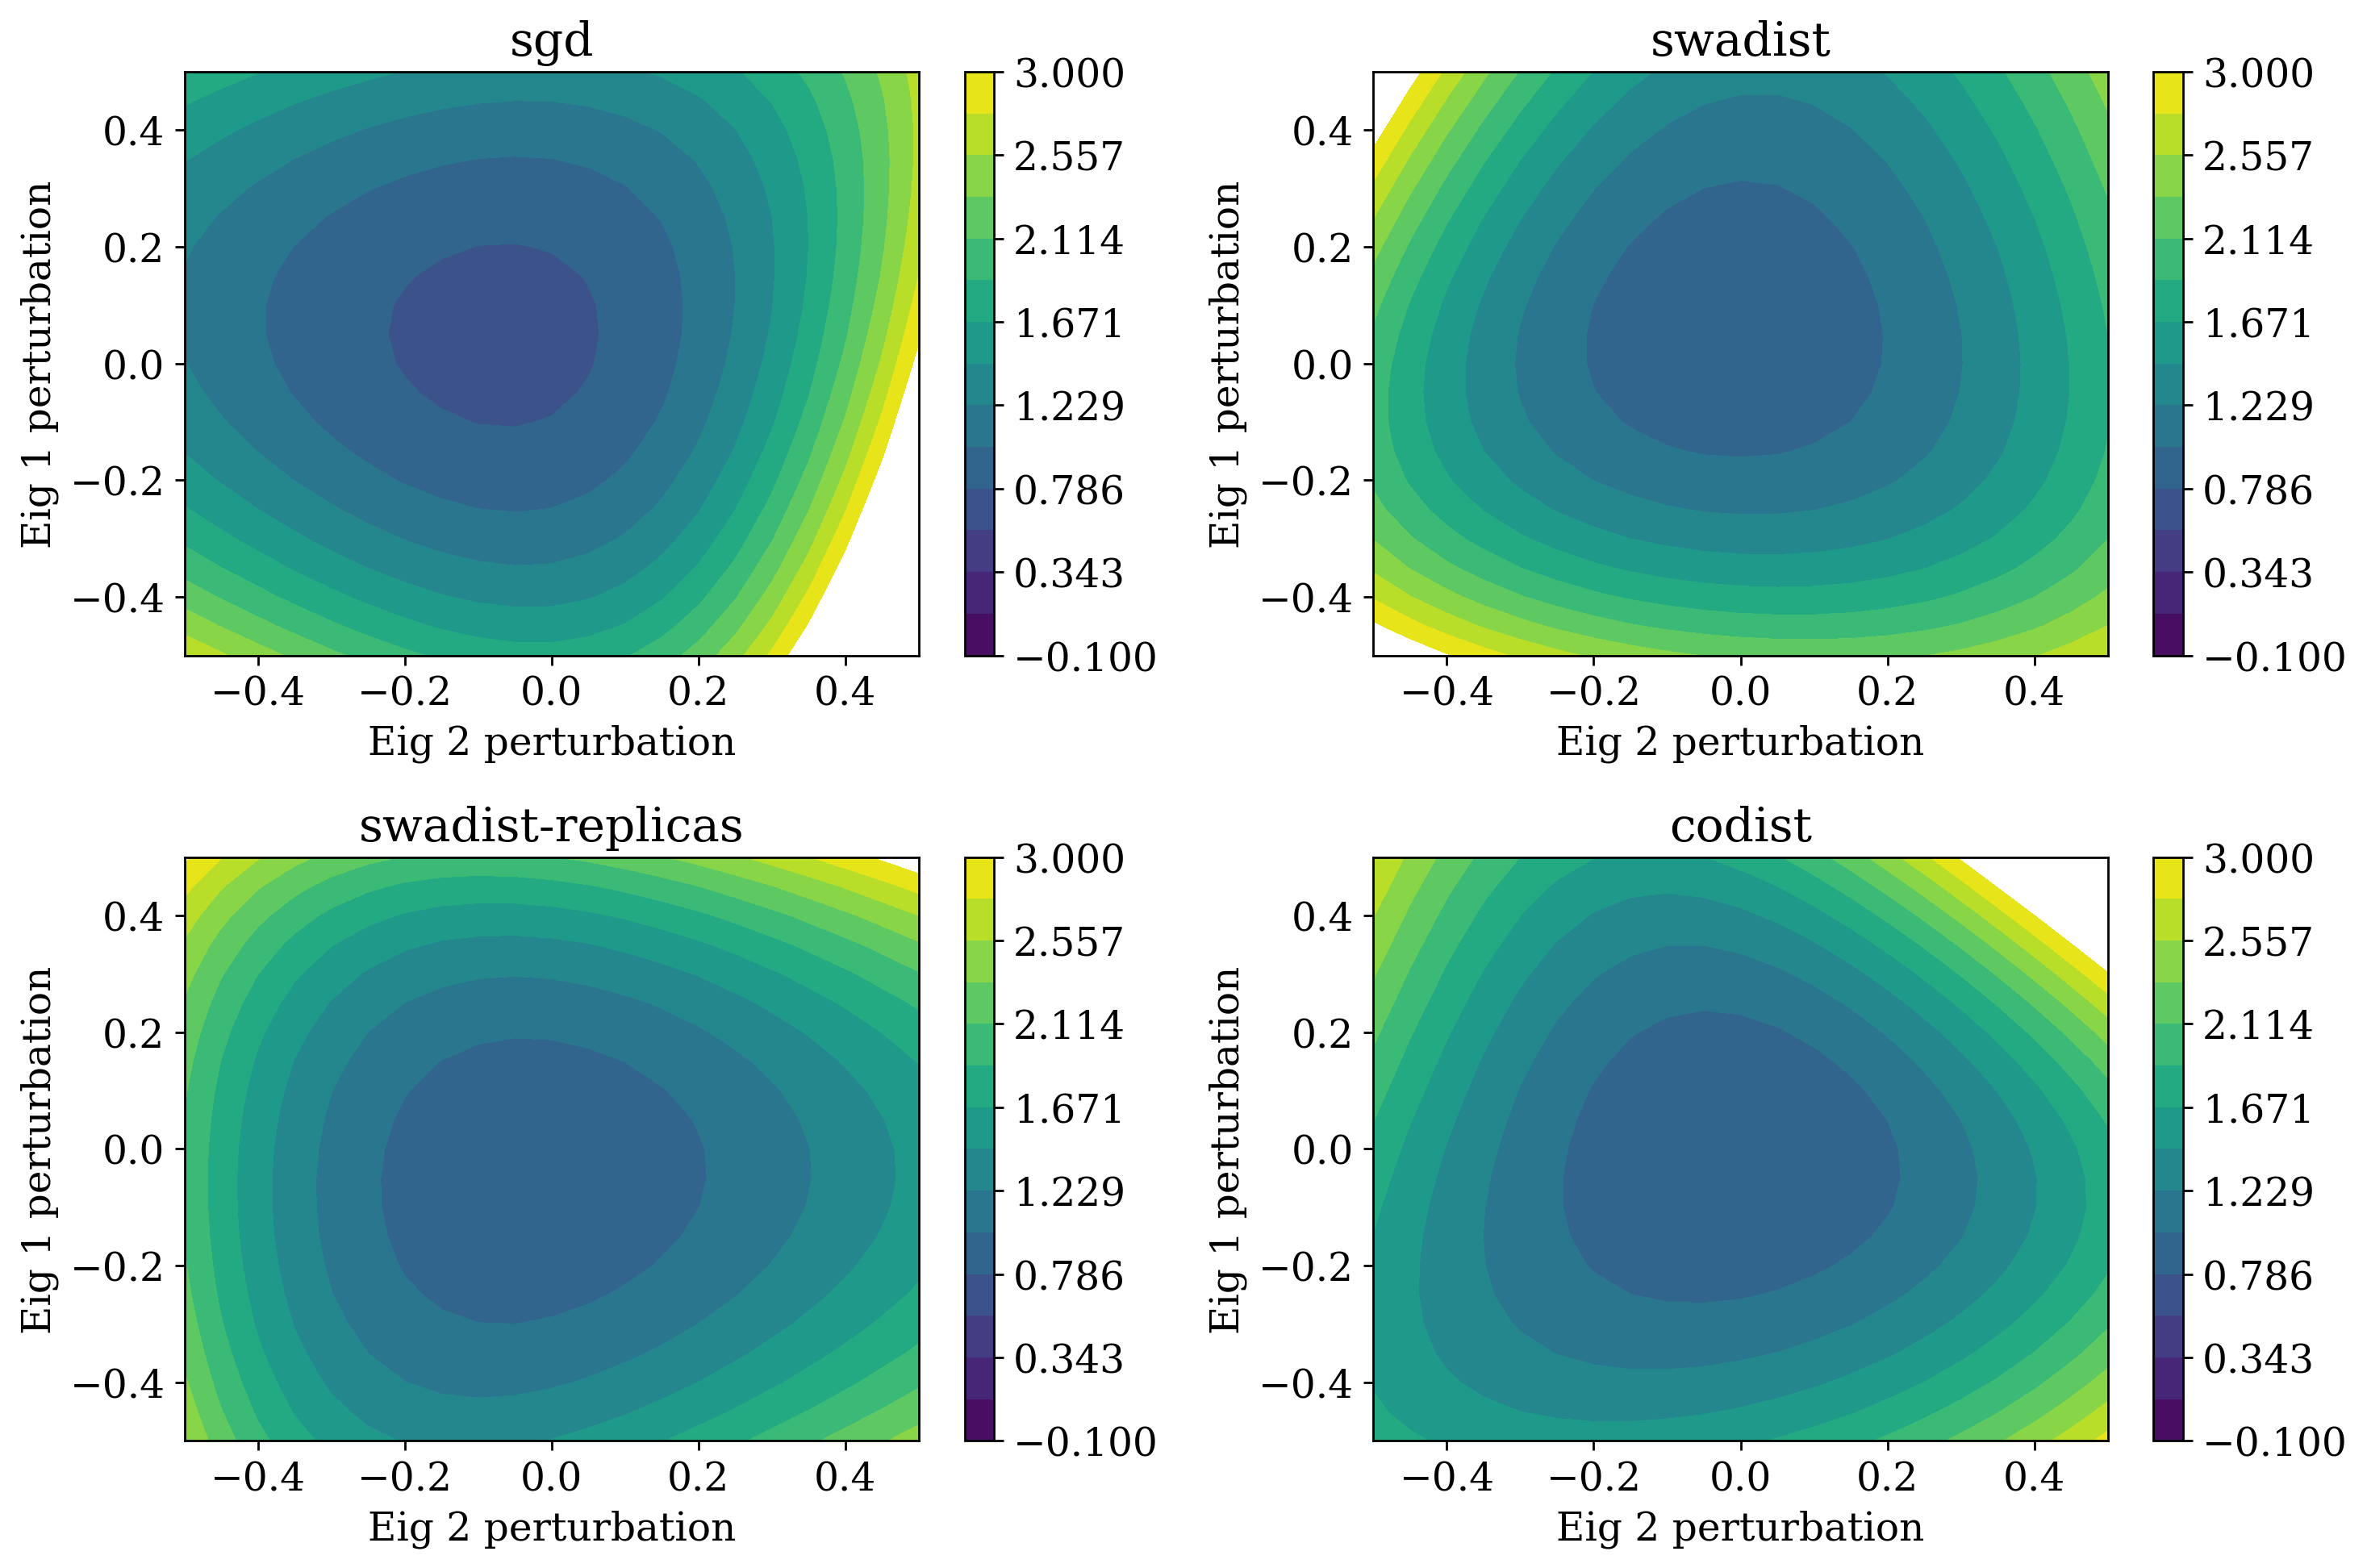

In [183]:
plot_hessian(currbs_paths, 
    # levels=np.logspace(-1, 0.7, 15))
    levels=np.linspace(-0.1, 3, 15))